## Journal 05 Effect of Density
Here we take the hierarchical model with a fixed core size and fixed uniform branching factor and examine the effect of a varying uniform density in the each layer


## Setup

We first introduce a bunch of functions to make the process in earlier documents faster. Nothing new is happenning here mathematically.

In [113]:
import networkx as nx
import numpy as np
from numpy.linalg import inv, cond,norm
import numpy.linalg as lin 
from scipy.linalg import svdvals 
import matplotlib.pyplot as plt
import helperfunctions.util
a = 6
c = 4

def make_n_layer(core, inner_weights, branching_factors):
    sizes = [ core ]
    cores = [ core ]
    for i in range(1, len(inner_weights)+1):
        sizes.append(sizes[i-1] * branching_factors[i-1])
        cores.append(cores[i-1] + sizes[i])
    n = sum(sizes)
    G = np.zeros((n,n))
    cur = sizes[0]
    for i in range(cores[0]):
        for j in range(inner_weights[0]):
            k = (i + j+1) % core
            G[i,k] = 1
        for j in range(branching_factors[0]):
            G[i, cur] = 1
            cur += 1
    for layer in range(1, len(inner_weights)  ):
        for i in range(cores[layer-1], cores[layer] ):
            for j in range(inner_weights[layer]):
                k = i + j  + 1 
                if(k >= cores[layer]):
                    overflow = k - cores[layer]
                    k = cores[layer - 1] + overflow
                    #print(n, k, j)
                G[i, k] = 1
            for j in range(branching_factors[layer]):
                G[i, cur] = 1
                cur += 1 
    ## Add in loop from last to first node
    for node in range(cores[-2], cores[-1]):
        G[node, node % cores[0]] = 1
    return cores, G 


cores, G = make_n_layer(2, [1,1], [2,2])
n = cores[-1]
I = np.eye(n,n)
rho = 0.95 / norm(G + G.T, ord=2)
B = inv(I - 2 * rho * G)
def slice(i, cores):
    n = cores[-1]
    slc = np.zeros((n,))
    if(i == 0):
        slc[0:cores[0]] = 1
        return slc 
    slc[cores[i-1]: cores[i]] = 1
    return slc 
    
def build_constraint(cores, B, a, c):
    n = len(cores)
    G = np.zeros((n,n))
    v = np.zeros((n,))
    ones = np.ones((cores[-1],))
    for i in range(n):
        for j in range(n):
            G[i,j] = slice(i, cores).T @ B @ slice(j, cores) + slice(j, cores).T @ B @ slice(i, cores)
        v[i] = a * slice(i, cores).T @ B @ ones + c * ones.T @ B @ slice(i, cores)
    return G, v

def price_from_small(cores, block_map, prices):
    n  = cores[-1]
    v = np.zeros((n,))
    v[0:cores[0]] = prices[ block_map[0]]
    for i in range(1, len(cores)):
        v[cores[i-1]: cores[i]] = prices[ block_map[i]]
    return v 



We test these functions by comparing price we get applied to a graph G vs the true optimal price.

In [69]:
A, v = build_constraint(cores, B, a, c)
small_prices = inv(A) @ v 
guess_price = price_from_small(cores, [0, 1, 2], small_prices)
true_price = helperfunctions.util.price_vector(a,c,rho, G)
max( abs(guess_price - true_price))
## These should match in value. 

1.199040866595169e-14

Next we compare the profits

In [83]:
def profit_from_spec(core, inner_weights, branching_factors):
    cores, G = make_n_layer(core, inner_weights, branching_factors)
    n = cores[-1]
    I = np.eye(n,n)
    rho = 0.95 / norm(G + G.T, ord=2)
    B = inv(I - 2 * rho * G)
    A, v = build_constraint(cores, B, a, c)
    small_prices = inv(A) @ v 
    price = price_from_small(cores, [0, 1, 2], small_prices)
    ones = np.ones((n,))
    profit = 0.5 * (price - c*ones).T @ B @ (a*ones - price)
    return profit, price, B 

cores, G = make_n_layer(4, [2,2], [2,2])
rho = 0.95 / norm(G + G.T, ord=2)
print(helperfunctions.util.optProfit(G, rho, a, c) - profit_from_spec(4, [2,2], [2,2])[0])

-2.842170943040401e-14


Now we introduce more functions to handle blocking. Again no new math just a cleaner system

In [71]:
def profit_with_block(core, inner_weights, branching_factors, blocks):
    cores, G = make_n_layer(core, inner_weights, branching_factors)
    n = cores[-1]
    I = np.eye(n,n)
    rho = 0.95 / norm(G + G.T, ord=2)
    B = inv(I - 2 * rho * G)
    A, v = build_constraint(cores, B, a, c)
    P = np.zeros((len(blocks), len(A)))
    block_map = [0 for i in range(len(A))]
    for i in range(len(blocks)):
        for j in blocks[i]:
            P[i, j] = 1
            block_map[j] = i 

    small_prices = inv(P @ A @ P.T) @ P @ v
    price = price_from_small(cores, block_map, small_prices)
    ones = np.ones((n,))
    profit = 0.5 * (price - c*ones).T @ B @ (a*ones - price)
    return profit, price

true_profit, true_price, B = profit_from_spec(4, [2,2], [2,2] )
profit_12, price_12 = profit_with_block(4, [2,2], [2,2], [[0], [1,2]])
ones = np.ones((len(B)))

diff = true_price - price_12 
print(0.25 * (a * diff.T @ B @ ones + c *ones.T @ B @ diff) - (true_profit - profit_12))


4.005684672847565e-13


We take $\frac{1}{4}$ instead of $\frac{1}{2}$ becase we have $B = (I - 2 * rho *G)^{-1}$ instead of $\frac{1}{2}(I - 2 * rho *G)^{-1}$


## Question 1: Does the core size affect the ranking of partition
We will vary the core size to test is the ranking of best to worst blocking every changes. We thought that it should note

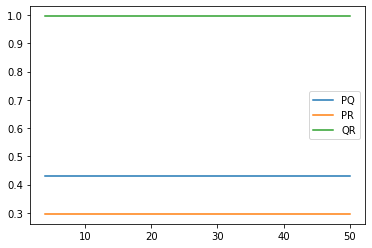

In [72]:
core_sizes = [4, 5,6,7,8,9, 15, 30, 40,50]
groups = {"pq" : [[0,1],[2]],
          "pr" : [[0,2],[1]],
          "qr" : [[0], [1,2]]}
def ranking(core_size, groups, inner_weights, branching):
    profits = {}
    for g in groups:
        profits[g],price = profit_with_block(core_size, inner_weights, branching, groups[g])
    result = [(name, profits[name]) for name in profits]
    result.sort(reverse=True, key= lambda x : x[1])
    return result

res = {"pq" : [] , "pr" : [], "qr" : [], "opt" : []}
for core_size in core_sizes:
    r = ranking(core_size, groups, [2,2], [5,5])
    res["opt"].append(profit_from_spec(core_size, [2,2], [5,5])[0])
    for i in range(3):
        res[r[i][0]].append(r[i][1] /res["opt"][-1] )
plt.plot(core_sizes, res["pq"], label="PQ")
plt.plot(core_sizes, res["pr"], label="PR")
plt.plot(core_sizes, res["qr"], label="QR")


plt.legend();

## Question 2 the effect of density 

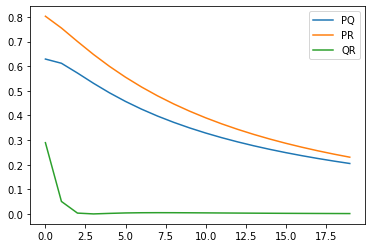

In [75]:
densities = [i for i in range(0,20)]
groups = {"pq" : [[0,1],[2]],
          "pr" : [[0,2],[1]],
          "qr" : [[0], [1,2]]}

res = {"pq" : [] , "pr" : [], "qr" : [], "opt" : []}
for d in densities:
    r = ranking(21, groups,[d,d],[6,6],)
    res["opt"].append(profit_from_spec(21, [d,d], [6,6])[0] )

    for i in range(3):
        res[r[i][0]].append(1 - r[i][1]/res["opt"][-1])
plt.plot(densities, res["pq"], label="PQ")
plt.plot(densities, res["pr"], label="PR")
plt.plot(densities, res["qr"], label="QR")
plt.legend();

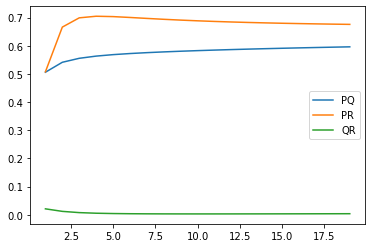

In [76]:
branch = [i for i in range(1,20)]
groups = {"pq" : [[0,1],[2]],
          "pr" : [[0,2],[1]],
          "qr" : [[0], [1,2]]}

res = {"pq" : [] , "pr" : [], "qr" : [], "opt" : []}
for b in branch:
    r = ranking(3, groups, [2,2], [b,b])
    res["opt"].append(profit_from_spec(3, [2,2], [b,b])[0] )

    for i in range(3):
        res[r[i][0]].append( 1 - r[i][1]/res["opt"][-1])
    
plt.plot(branch, res["pq"], label="PQ")
plt.plot(branch, res["pr"], label="PR")
plt.plot(branch, res["qr"], label="QR")
plt.legend();

## Summary
We see that increasing the core size has no effect on regret, increasing the density decreases the regret, and for the braching factor it seem to have a large effect early then nearly no effect. 

# Losses
Let $p$ be the optimal price vector for a network and let q be the optimal price vector of the graph when we are given block information. I have tested more including on graphs with loops and think the following are equivalent in value 
1. $  Profit_G(p) -  Profit_G(u)$
2. $ 0.5 ( a * d^T B 1 + c 1^T B d) $
3. $ ( p^T B p - u^T B u )$

Where $Profit_G(v)$ is the profit when applying prices v on graph G and $d = p - q $ and $B = 0.5 (I - 2*\rho * G)^{-1}$

The questions I have are 1) Is this helpful to characterize the loss 2) Fixing p are these the only prices q that satisfy this?

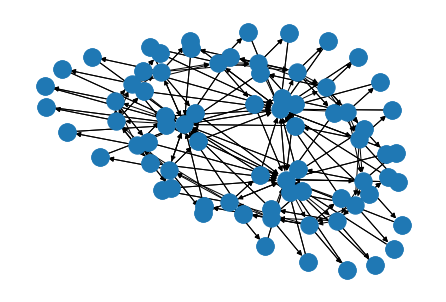

In [114]:
cores, G =  make_n_layer(3, [2,2], [6,6])
nx.draw_spectral(nx.DiGraph(G))
## There is a branching factor of 6 from layer two to three even though the picture doesn't show it
## This is a issue with the graph drawing function but this one still looks the best


In [120]:
profit, price, B = profit_from_spec(3, [2,2], [6,6])

profit_guess, price_guess = profit_with_block(3, [2,2], [6,6], groups["pr"])
profit_guess1, price_guess1 = profit_with_block(3, [2,2], [6,6], groups["qr"])
ones = np.ones((cores[-1], ))
## Lower is better because that means less loss
loss = profit - profit_guess
d = price - price_guess 

print(loss)
print( 0.25 * (a* d.T @ B @ ones + c * ones.T @ B @ d))
print( 0.5 * (price.T @ B @ price - price_guess.T @ B @ price_guess))

398.35905019925127
398.3590501992512
398.35905019925303


To begin answering question two we can note that if other vectors do satisfy this relation they are distributed in an odd manner. For example, the set of solutions is not a subspace. Perhaps you can get new solutions if you renormalize in some, currently unsure

In [140]:
profit_guess, price_guess = profit_with_block(3, [2,2], [6,6], groups["pr"])
profit_guess1, price_guess1 = profit_with_block(3, [2,2], [6,6], groups["qr"])
price_guess_comb = 0.5 * (price_guess + price_guess1)
rho_g = 0.95 / lin.norm(G + G.T, ord=2)
profit_guess_comb = helperfunctions.util.computeProfit(G, price_guess_comb, rho_g, a, c)
loss = profit - profit_guess_comb
d = price - price_guess_comb
print(loss)
print( 0.25 * (a* d.T @ B @ ones + c * ones.T @ B @ d))
print( 0.5 * (price.T @ B @ price - price_guess_comb.T @ B @ price_guess_comb))

200.04449451539767
289.184066056118
378.3236375968372


An additional note is that since I am saying the loss is of the form $p^T B p - u^T B u$ to minimize the loss we should maximize $u^T B u$. This is perhaps true with the important caveat that u is a vector satisfying other constraints mainly $P A P^T u = P b$ where $A p = b$ was the system that gave us the original optimal price and P was some partition of components of the graph into blocks. $max u^T B u$ with no constraints should be $+\infty$ in most cases. 

In my mind the goals if this part is interesting is in some order
1. Math proof that this is true for optimal prices we got from partitions
2. Insight into if/when the earlier 3 statements are true for other vectors
3. Does this form help get useful bounds for the loss? 